In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', 'Final Products', 'AOI_full_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', 'Final Products', 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")
print(regions_gdf.crs)
print(rgi_gdf.crs)

ESRI:102025
ESRI:102025


In [4]:
# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [10]:
all_regions = np.unique(rgi_gdf['o3region'].values)
c=0
for r in all_regions:
    print("Starting region", r)
    # if r!=1: break
    
    # subset to the rgi in this region
    gdf_susbet = rgi_gdf[rgi_gdf['o3region']==r]
    
    # define path to the region's total count
    path_open = os.path.join(folder_HMA, "Datasets", "GEE outputs", "total counts",
                             f"total_count_r{str(r).zfill(2)}.tif")
    
    # open with riox
    xr_count = riox.open_rasterio(path_open, masked=False,
                                   chunks={"x": 'auto', "y": 'auto'}).astype(float)
    
    # rename bands to the years which they represent
    year_names = [int(i) for i in list(xr_count.long_name)]
    xr_count = xr_count.rename({"band":"year"})
    xr_count['year'] = year_names
    
    # process each glacier
    for idx, row in gdf_susbet.iterrows():
        c+=1
        # if c>1: continue

        # grab glacier geometry, region, rgiid
        rgi_id = row['rgi_id']
        region = row['o3region']
        geom = row['geometry']
        
        # print progress
        if c%10==0: print(r, c, "of", len(rgi_gdf), rgi_id)
        # print(r, c, "of", len(rgi_gdf), rgi_id)
        
        # open glacier mask
        path_mask = os.path.join(folder_glaciers, rgi_id, 'glacier_mask.tif')
        xr_mask = riox.open_rasterio(path_mask, masked=False).squeeze(drop=True)

        # subset count to the extent of the mask (buffered by a bit)
        xs = [ np.nanmin(xr_mask['x'])-200, np.nanmax(xr_mask['x'])+200 ]
        ys = [ np.nanmin(xr_mask['y'])-200, np.nanmax(xr_mask['y'])+200 ]
        xr_count_subset = xr_count.sel(x=slice(xs[0], xs[1]), y=slice(ys[1], ys[0]))
        
        # clip the water xr to the rgi geometry (buffered by a little bit), fill nan with 0
        xr_count_clipped = xr_count_subset.rio.clip([geom.buffer(200)])
        xr_count_clipped = xr_count_clipped.where(~np.isnan(xr_count_clipped), 0)
        
        # interpolate to the mask grid
        xr_count_interp = xr_count_clipped.interp_like(xr_mask, method='nearest', assume_sorted=False)
        xr_count_interp = xr_count_interp.where(xr_mask>0, 0).rename('data').astype("uint8")

        # save as tif
        out_path = os.path.join(folder_glaciers, rgi_id, 'glacier_total_count.tif')
        xr_count_interp.rio.to_raster(out_path, compress='LZW', tiled=True)

        # delete nc if it exists
        # nc_path = os.path.join(folder_glaciers, rgi_id, 'glacier_total_count.nc')
        # if os.path.exists(nc_path):
        #     os.remove(nc_path)
        # break
    #     break
    # break
print("All done!")

Starting region 1
1 1 of 769 RGI2000-v7.0-G-15-18018
1 2 of 769 RGI2000-v7.0-G-15-18022
1 3 of 769 RGI2000-v7.0-G-15-18023
1 4 of 769 RGI2000-v7.0-G-15-18029
1 5 of 769 RGI2000-v7.0-G-15-18045
1 6 of 769 RGI2000-v7.0-G-15-18077
1 7 of 769 RGI2000-v7.0-G-15-18121
1 8 of 769 RGI2000-v7.0-G-15-18122
1 9 of 769 RGI2000-v7.0-G-15-18123
Starting region 2
2 10 of 769 RGI2000-v7.0-G-15-17006
2 11 of 769 RGI2000-v7.0-G-15-17010
2 12 of 769 RGI2000-v7.0-G-15-17023
2 13 of 769 RGI2000-v7.0-G-15-17098
Starting region 3
3 14 of 769 RGI2000-v7.0-G-15-13376
3 15 of 769 RGI2000-v7.0-G-15-13381
3 16 of 769 RGI2000-v7.0-G-15-13389
3 17 of 769 RGI2000-v7.0-G-15-14679
3 18 of 769 RGI2000-v7.0-G-15-14680
3 19 of 769 RGI2000-v7.0-G-15-14683
3 20 of 769 RGI2000-v7.0-G-15-14828
3 21 of 769 RGI2000-v7.0-G-15-15007
3 22 of 769 RGI2000-v7.0-G-15-15595
3 23 of 769 RGI2000-v7.0-G-15-15596
3 24 of 769 RGI2000-v7.0-G-15-15598
3 25 of 769 RGI2000-v7.0-G-15-15605
3 26 of 769 RGI2000-v7.0-G-15-15685
3 27 of 769 RGI2000

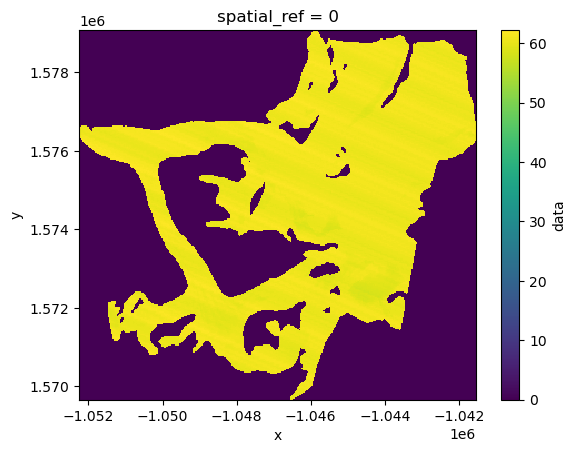

In [11]:
xr_count_interp.mean('year').plot()

In [12]:
xr_count_interp

<xarray.DataArray 'data' (year: 35, y: 314, x: 357)>
dask.array<astype, shape=(35, 314, 357), dtype=uint8, chunksize=(35, 314, 357), chunktype=numpy.ndarray>
Coordinates:
  * year         (year) int32 1989 1990 1991 1992 1993 ... 2020 2021 2022 2023
    spatial_ref  int32 0
  * x            (x) float64 -1.052e+06 -1.052e+06 ... -1.042e+06 -1.042e+06
  * y            (y) float64 1.579e+06 1.579e+06 1.579e+06 ... 1.57e+06 1.57e+06
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('1989', '1990', '1991', '1992', '1993', '1994', '1995', ...